In [2]:
#!pip install streamlit
!pip install mysql-connector-python

In [1]:
import streamlit as st
import mysql.connector
import pandas as pd

In [2]:
mydb = mysql.connector.connect(
                        host="localhost",
                        user="root",
                        password="root",
                        database="gravity_books"
                    )
mycursor = mydb.cursor()
mycursor.execute('''
                SELECT
    c.customer_id,
    b.book_id,
    b.title,
    b.language_id,
    l.language_name,
    b.num_pages,
    b.publication_date,
    p.publisher_name,
    a.author_name,
    ol.price,
    o.order_date
FROM
    customer c
JOIN
    cust_order o ON c.customer_id = o.customer_id
JOIN
    order_line ol ON o.order_id = ol.order_id
JOIN
    book b ON ol.book_id = b.book_id
LEFT JOIN
    publisher p ON b.publisher_id = p.publisher_id
LEFT JOIN
    book_language l ON b.language_id = l.language_id
LEFT JOIN
    book_author ba ON b.book_id = ba.book_id
LEFT JOIN
    author a ON ba.author_id = a.author_id
WHERE
    o.order_date IS NOT NULL
ORDER BY
    o.order_date DESC;
       ''')
result_1 = mycursor.fetchall()


In [3]:
Book_df = pd.DataFrame(result_1,columns=['customer_id','book_id','book_title','book_language_id','book_language_name',
'num_pages','publication_date','publisher_name','author_name','book_price','order_date']).reset_index(drop=True)

In [4]:
#Book_Book_Book_Book_df['Published_Year'] = Book_df['publication_date'].dt.year
Book_df['Published_Year'] = pd.DatetimeIndex(Book_df['publication_date']).year

In [5]:
Book_df['author_name'].fillna('Unknown Author', inplace=True)

In [26]:
"""
n = len(pd.unique(Book_df['author_name']))
n
c= Book_df.author_name.drop_duplicates().size
c"""

8217

In [6]:
Book_df['year'] = Book_df['order_date'].dt.year
Book_df['month'] = Book_df['order_date'].dt.month
Book_df['day'] = Book_df['order_date'].dt.day
Book_df['day_of_week'] = Book_df['order_date'].dt.dayofweek

# Calculate Days Since Last Order
Book_df = Book_df.sort_values(by=['customer_id', 'order_date'])
Book_df['days_since_last_order'] = Book_df.groupby('customer_id')['order_date'].diff().dt.days.fillna(0)



In [7]:
Book_df['published_decade'] = (Book_df['Published_Year'] // 10) * 10
Book_df['published_decade'] = Book_df['published_decade'].astype(str)  #

In [24]:
Book_df.sample(3)

,customer_id,book_id,book_title,book_language_id,book_language_name,num_pages,publication_date,publisher_name,author_name,book_price,order_date,Published_Year,year,month,day,day_of_week,days_since_last_order,published_decade
28966,317,8914,Wicked: The Grimmerie,1,English,192,2005-10-26,Hachette Books,David Cote,5.31,2022-09-12 01:47:44,2005,2022,9,12,0,0.0,2000
11315,43,1871,Bakkhai,1,English,160,2001-02-22,Oxford University Press USA,Euripides,18.37,2024-01-23 06:34:22,2001,2024,1,23,1,25.0,2000
21718,1397,3134,No Country for Old Men,1,English,309,2006-07-11,Vintage,Cormac McCarthy,8.13,2023-04-02 13:11:26,2006,2023,4,2,6,0.0,2000


In [10]:
Book_df.columns

Index(['customer_id', 'book_id', 'book_title', 'book_language_id',
       'book_language_name', 'num_pages', 'publication_date', 'publisher_name',
       'author_name', 'book_price', 'order_date', 'Published_Year', 'year',
       'month', 'day', 'day_of_week', 'days_since_last_order',
       'published_decade', 'page_category'],
      dtype='object')

In [9]:
bins = [0, 2000, 4000, 6000, 8000]
labels = ['Short', 'Medium', 'Long', 'Very Long']
Book_df['page_category'] = pd.cut(Book_df['num_pages'], bins=bins, labels=labels)

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

# Columns to scale
price_column = 'book_price'
days_column = 'days_since_last_order'

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply MinMaxScaler to 'book_price'
Book_df[f'{days_column}_scaled'] = minmax_scaler.fit_transform(Book_df[[days_column]])

# Apply StandardScaler to 'days_since_last_order'
Book_df[f'{price_column}_scaled'] = standard_scaler.fit_transform(Book_df[[price_column]])

# Save the scalers to pickle files
with open('minmax_scaler_price.pkl', 'wb') as file:
    pickle.dump(minmax_scaler, file)

with open('standard_scaler_days.pkl', 'wb') as file:
    pickle.dump(standard_scaler, file)

# Verify the transformations
print(Book_df[[f'{price_column}_scaled', f'{days_column}_scaled']].head())


import numpy as np

# Load scalers
with open('minmax_scaler_price.pkl', 'rb') as file:
    minmax_scaler = pickle.load(file)

with open('standard_scaler_days.pkl', 'rb') as file:
    standard_scaler = pickle.load(file)
"""
# Example user input
user_input = {
    'book_price': 500,  # User-provided price
    'days_since_last_order': 15  # User-provided days
}

# Transform user inputs
scaled_price = minmax_scaler.transform([[user_input['book_price']]])[0][0]
scaled_days = standard_scaler.transform([[user_input['days_since_last_order']]])[0][0]

# Combine scaled inputs
scaled_input = np.array([scaled_price, scaled_days])

print(f"Scaled Input: {scaled_input}") 4691970078356060 12/27 724"""


       book_price_scaled  days_since_last_order_scaled
37945          -0.721250                      0.000000
37946          -0.721250                      0.000000
37713           0.777597                      0.005629
37714           0.777597                      0.000000
37715           1.137529                      0.000000


'\n# Example user input\nuser_input = {\n    \'book_price\': 500,  # User-provided price\n    \'days_since_last_order\': 15  # User-provided days\n}\n\n# Transform user inputs\nscaled_price = minmax_scaler.transform([[user_input[\'book_price\']]])[0][0]\nscaled_days = standard_scaler.transform([[user_input[\'days_since_last_order\']]])[0][0]\n\n# Combine scaled inputs\nscaled_input = np.array([scaled_price, scaled_days])\n\nprint(f"Scaled Input: {scaled_input}") 4691970078356060 12/27 724'

In [13]:
Book_df.columns


In [16]:
df = Book_df.drop(['book_id', 'book_language_id',
        'publication_date','num_pages',
        'order_date', 'Published_Year', 'year',
       'month', 'day', 'day_of_week'], axis = 1)

In [17]:
df.sample(6)

,customer_id,book_title,book_language_name,publisher_name,author_name,book_price,days_since_last_order,published_decade,page_category
27905,337,And Still I Rise,English,Random House,Linda Sunshine,3.39,0.0,2000,Short
13010,1478,1599: A Year in the Life of William Shakespeare,English,Faber & Faber,James Shapiro,2.76,0.0,2000,Short
13419,224,Ilium (Ilium #1),English,HarperTorch,Dan Simmons,1.98,79.0,2000,Short
29670,167,The Wish Giver: Three Tales of Coven Tree,English,HarperCollins,Andrew Glass,4.47,241.0,2010,Short
5495,384,Azumanga Daioh Vol. 3 (Azumanga Daioh #3),English,ADV Manga,あずま きよひこ,0.50,0.0,2000,Short
31563,72,The Teeth of the Tiger (Jack Ryan Universe #12),English,Penguin Books Ltd.,Tom Clancy,13.15,5.0,2000,Short


In [14]:
l = df['publisher_name'].unique()


In [ ]:
"""
book_title=df['book_title'].unique()
print (book_title)
oh1=OneHotEncoder()
df['encoded_book_title'] = oh1.fit_transform(df['book_title'])

with open('book_title.pkl', 'wb') as file:
    pickle.dump(oh1, file)

with open('book_title.pkl', 'rb') as file:
    fse = pickle.load(file)

print (df['encoded_book_title'].unique())"""

In [27]:
df.columns

Index(['book_price', 'days_since_last_order', 'customer_id_encoded',
       'book_title_encoded', 'book_language_name_encoded',
       'publisher_name_encoded', 'author_name_encoded',
       'published_decade_encoded', 'page_category_encoded'],
      dtype='object')

In [19]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import pickle

In [26]:
df = df.drop(['yeojohnson_days_since_last_order'], axis = 1)

In [20]:
from sklearn.preprocessing import LabelEncoder
columns_to_encode = ['customer_id', 'book_title', 'book_language_name', 'publisher_name',
       'author_name', 'published_decade', 'page_category']
# Initialize encoders
label_encoders = {}

for column in columns_to_encode:
    le = LabelEncoder()
    df[f'{column}_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le  # Save encoder for reuse
    df.drop(column, axis=1, inplace=True)  # Drop the original column if desired

    with open(f'{column}_encoder.pkl', 'wb') as file:
        pickle.dump(le, file)

    # Reload the encoder for verification (optional)
    with open(f'{column}_encoder.pkl', 'rb') as file:
        loaded_encoder = pickle.load(file)

print(df.head())

      book_price  days_since_last_order  customer_id_encoded  \
37945       5.95                    0.0                    0   
37946       5.95                    0.0                    0   
37713      14.57                    6.0                    0   
37714      14.57                    0.0                    0   
37715      16.64                    0.0                    0   

       book_title_encoded  book_language_name_encoded  publisher_name_encoded  \
37945                1366                           5                    1050   
37946                1366                           5                    1050   
37713                5648                          24                    1065   
37714                5648                          24                    1065   
37715                2416                           5                      56   

       author_name_encoded  published_decade_encoded  page_category_encoded  
37945                 1977                        

In [51]:
df.dtypes

book_price                     object
days_since_last_order         float64
customer_id_encoded             int64
book_title_encoded              int32
book_language_name_encoded      int32
publisher_name_encoded          int32
author_name_encoded             int32
published_decade_encoded        int32
page_category_encoded           int32
dtype: object

Text(0.5, 0, 'book_price')

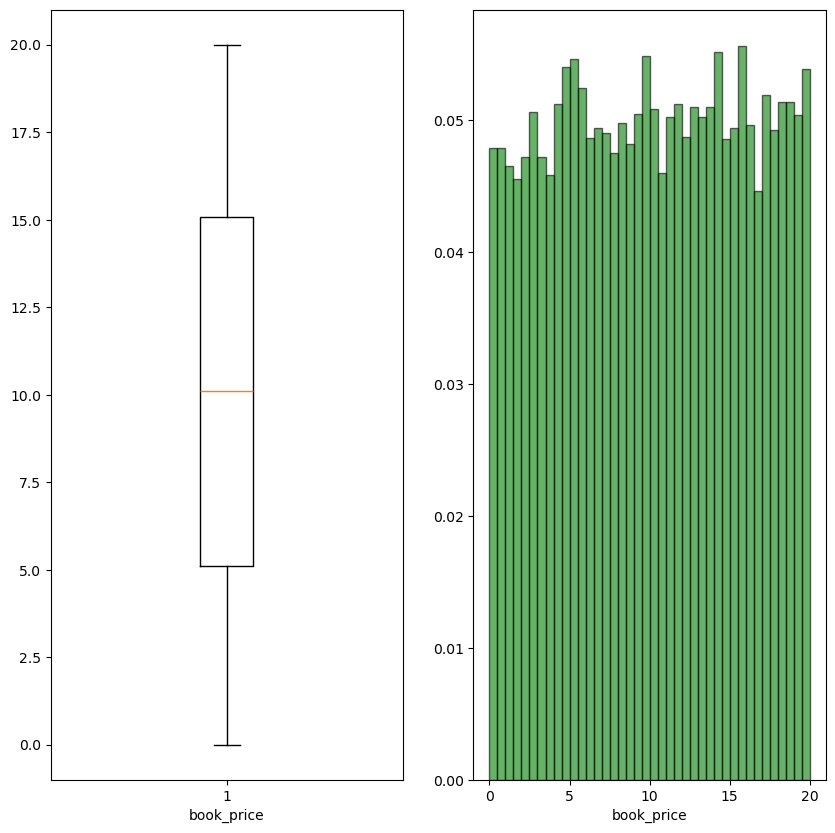

In [52]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(1,2,figsize=(10,10))
axs[0].boxplot(x=df['book_price'].apply(float))
axs[0].set_xlabel('book_price')
axs[1].hist(df['book_price'].apply(float),bins=40, density=True, alpha=0.6, color='g', edgecolor='black', label='Histogram')
axs[1].set_xlabel('book_price')

In [53]:
df['book_price'].skew()

-0.01288822657808754

Text(0.5, 0, 'days_since_last_order')

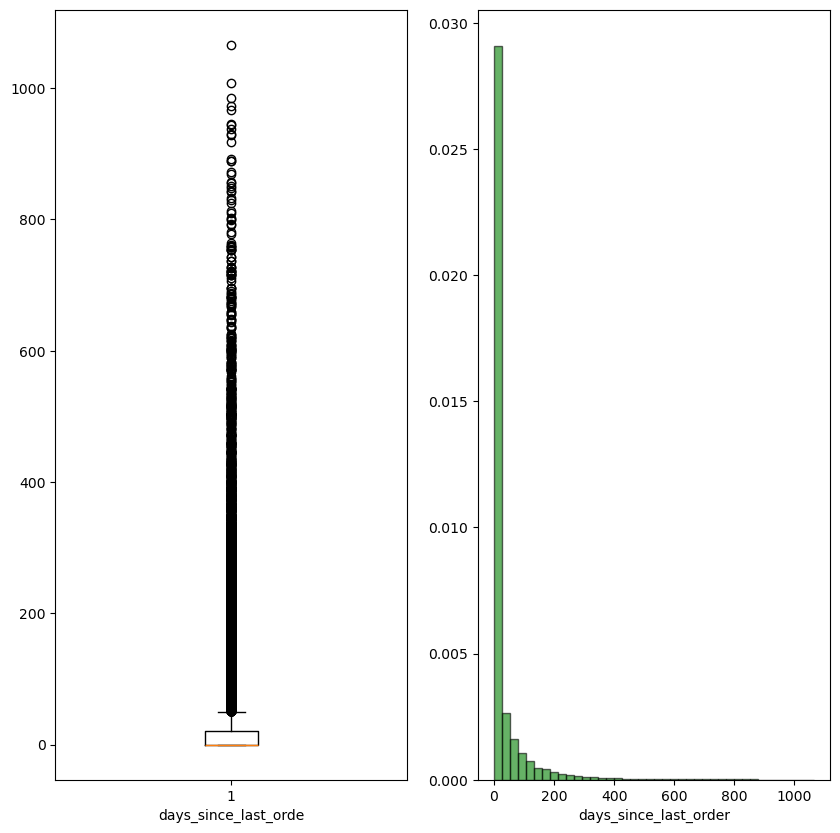

In [55]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(1,2,figsize=(10,10))
axs[0].boxplot(x=df['days_since_last_order'])
axs[0].set_xlabel('days_since_last_orde')
axs[1].hist(df['days_since_last_order'],bins=40, density=True, alpha=0.6, color='g', edgecolor='black', label='Histogram')
axs[1].set_xlabel('days_since_last_order')

In [62]:
import numpy as np
df['sqrt_days_since_last_order'] = np.sqrt(df['days_since_last_order'])

In [21]:
from sklearn.preprocessing import PowerTransformer

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
df['yeojohnson_days_since_last_order'] = pt.fit_transform(df[['days_since_last_order']])


In [23]:
df['yeojohnson_days_since_last_order'].skew()

0.7323708938810028

Text(0.5, 0, 'yeojohnson_days_since_last_order')

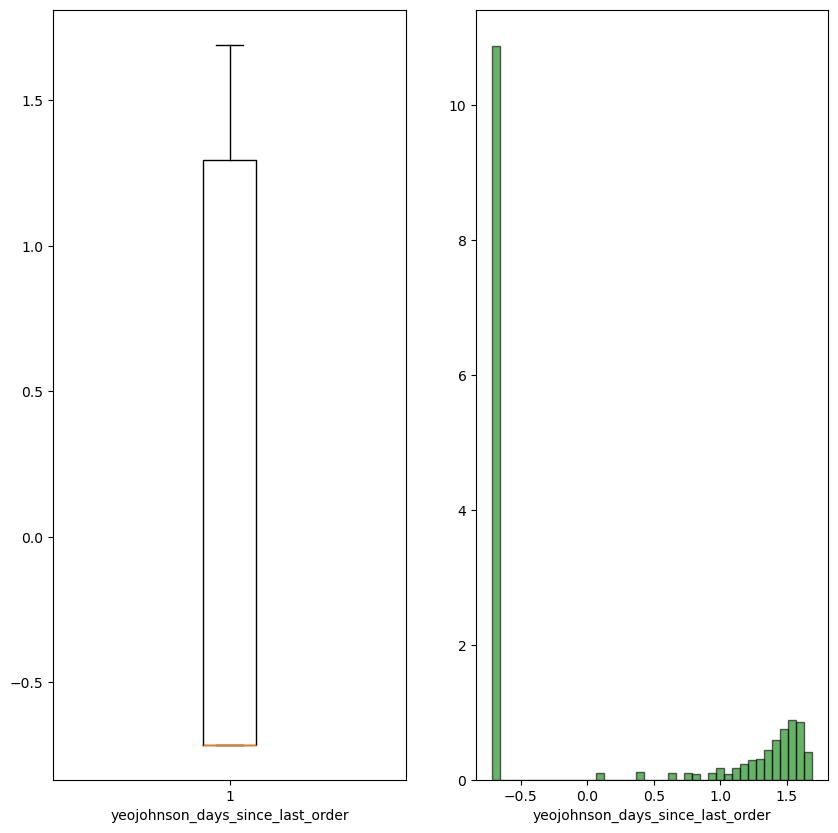

In [67]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(1,2,figsize=(10,10))
axs[0].boxplot(x=df['yeojohnson_days_since_last_order'])
axs[0].set_xlabel('yeojohnson_days_since_last_order')
axs[1].hist(df['yeojohnson_days_since_last_order'],bins=40, density=True, alpha=0.6, color='g', edgecolor='black', label='Histogram')
axs[1].set_xlabel('yeojohnson_days_since_last_order')

In [ ]:
# Access the encoder for 'book_title'
book_title_encoder = reloaded_encoders['book_title']

# Example user input
user_book_title = "Some Book Title"  # Replace with actual user input

# Transform user input
if user_book_title in book_title_encoder.classes_:
    encoded_book_title = book_title_encoder.transform([user_book_title])[0]
    print(f"Encoded book title: {encoded_book_title}")
else:
    print(f"The book title '{user_book_title}' is not in the encoder's training data.")
    encoded_book_title = -1  # Placeholder for unknown titles

# (Optional) Decode back to original
if encoded_book_title != -1:
    decoded_book_title = book_title_encoder.inverse_transform([encoded_book_title])
    print(f"Decoded book title: {decoded_book_title[0]}")

In [28]:
label_encoders

{'book_title': LabelEncoder(),
 'author_name': LabelEncoder(),
 'publisher_name': LabelEncoder()}

In [25]:
columns_to_encode = ['book_title', 'author_name', 'publisher_name']

# Dictionary to store encoders
encoders = {}

# Loop through each column
for column in columns_to_encode:
    # Get unique values for debugging or reference
    unique_values = df[column].unique()
    print(f"Unique values in '{column}': {unique_values}")
    
    # Initialize and fit the encoder
    oh1 = OneHotEncoder(sparse=True)
    encoded_data = oh1.fit_transform(df[[column]])
    
    # Save the encoder to a pickle file
    with open(f'{column}_encoder.pkl', 'wb') as file:
        pickle.dump(oh1, file)

    # Reload the encoder for verification (optional)
    with open(f'{column}_encoder.pkl', 'rb') as file:
        loaded_encoder = pickle.load(file)
    
    # Add encoded columns to DataFrame with meaningful names
    encoded_columns = pd.DataFrame(
        encoded_data,
        columns=[f"{column}_{cat}" for cat in oh1.categories_[0]]
    )
    df = pd.concat([df, encoded_columns], axis=1)
    
    # Drop the original column if desired
    df.drop(column, axis=1, inplace=True)
    
    # Store the encoder in a dictionary for later use
    encoders[column] = loaded_encoder

# Check the result
print(df.head())

Unique values in 'book_title': ['Collected Stories  1911-1937'
 'Sunny The Yellow Fairy (Rainbow Magic  #3)' 'Frost' ...
 'The Twelfth Card (Lincoln Rhyme  #6)' "Problems of Dostoevsky's Poetics"
 "Margaret Atwood's Power: Mirrors  Reflections and Images in Select Fiction and Poetry"]


c:\Users\RISHI\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ValueError: Shape of passed values is (38614, 1), indices imply (38614, 9092)

In [34]:
df.columns

Index(['book_price', 'days_since_last_order', 'customer_id_encoded',
       'book_title_encoded', 'book_language_name_encoded',
       'publisher_name_encoded', 'author_name_encoded',
       'published_decade_encoded', 'page_category_encoded'],
      dtype='object')

In [29]:
dfbkp = df

In [58]:
df =dfbkp

In [59]:
features = ['book_price', 'days_since_last_order',
       'customer_id_encoded',
       'book_language_name_encoded', 'publisher_name_encoded',
       'author_name_encoded', 'published_decade_encoded',
       'page_category_encoded']
target = 'book_title_encoded'


In [52]:
from sklearn.model_selection import train_test_split
'''
X = df[features].values  # Independent variables
y = df[target].values    # Target variable'''

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((30891, 8), (7723, 8), (30891,), (7723,))

In [60]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((30891, 8), (7723, 8), (30891,), (7723,))

In [55]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
scalerx1 = StandardScaler()
X_train_scaled = scalerx1.fit_transform(X_train)


In [64]:
scalery1 = StandardScaler()
X_test_scaled = scalery1.fit_transform(X_test)

In [65]:
with open('scalerx1.pkl', 'wb') as file:
    pickle.dump(scalerx1, file)
with open('scalerx1.pkl', 'rb') as file:
    scaled_datax = pickle.load(file)  

with open('scalery1.pkl', 'wb') as file:
    pickle.dump(scalery1, file)
with open('scalery1.pkl', 'rb') as file:
    scaled_datay = pickle.load(file) 

In [ ]:
!pip install tensorflow

In [78]:
!pip install streamlit-option-menu

  Using cached streamlit-1.41.1-py2.py3-none-any.whl.metadata (8.5 kB)
   ---------------------------------------- 0.0/829.3 kB ? eta -:--:--
   ---------------------------------------- 10.2/829.3 kB ? eta -:--:--
   - ------------------------------------- 30.7/829.3 kB 435.7 kB/s eta 0:00:02
   - ------------------------------------- 41.0/829.3 kB 393.8 kB/s eta 0:00:03
   --- ----------------------------------- 81.9/829.3 kB 459.5 kB/s eta 0:00:02
   ---- ---------------------------------- 92.2/829.3 kB 476.3 kB/s eta 0:00:02
   ----- -------------------------------- 112.6/829.3 kB 437.6 kB/s eta 0:00:02
   ------ ------------------------------- 143.4/829.3 kB 448.2 kB/s eta 0:00:02
   ------- ------------------------------ 163.8/829.3 kB 468.3 kB/s eta 0:00:02
   -------- ----------------------------- 194.6/829.3 kB 454.0 kB/s eta 0:00:02
   --------- ---------------------------- 204.8/829.3 kB 414.8 kB/s eta 0:00:02
   ---------- --------------------------- 225.3/829.3 kB 416.7 kB/

In [67]:
num_classes = len(df['book_title_encoded'].unique())

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
model2 = Sequential()
#input layer - 22 (columns) - developer scope
model2.add(Dense(128,input_dim = X_train_scaled.shape[1],activation="relu")) #hl1
model2.add(Dense(64,activation="relu")) #hl 2
model2.add(Dense(28,activation="relu")) #hl 3
model2.add(Dense(14,activation="relu")) #hl 4
model2.add(Dense(6,activation="relu")) #hl 5
model2.add(Dense(units=num_classes, activation='softmax')) #output
model2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 28)             │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 14)             │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 9092)           │        63,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,368 (294.41 KB)

 Trainable params: 75,368 (294.41 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
model2.fit(X_train,y_train,epochs=70)

Epoch 1/70
966/966 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.0615 - loss: 5.8337
Epoch 2/70
966/966 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.0643 - loss: 5.7113
Epoch 3/70
966/966 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.0700 - loss: 5.5959
Epoch 4/70
966/966 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.0731 - loss: 5.5412
Epoch 5/70
966/966 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.0770 - loss: 5.4732
Epoch 6/70
966/966 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.0755 - loss: 5.4149
Epoch 7/70
966/966 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.0743 - loss: 5.3713
Epoch 8/70
966/966 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.0789 - loss: 5.3081
Epoch 9/70
966/966 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.0821 - loss: 5.2844
Epoch 10/70
966/966 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.0837 - loss: 5.2089
Epoch 11/70
966/966 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.0843 - loss: 5.1858
Epoch 12/70
966/966 ━━━━━━━━━━━━━━━━━━━━ 8s 

In [76]:
from tensorflow.keras.models import load_model
model2.save('Book_Recommendation.h5')
# Load the model
#model_saved = load_model("model2.h5")



In [77]:
model = load_model("Book_Recommendation.h5")

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(8,input_dim = df.shape[1],activation="tanh")) #hl1
model.add(Dense(4,activation="tanh")) #hl 2
model.add(Dense(8,activation="tanh")) #hl 3
model.add(Dense(3,activation="linear")) #output - note the data set is continious hence using linear
model.compile(optimizer="adam",loss="mean_squared_error" , metrics=[tf.keras.metrics.R2Score(),tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanAbsolutePercentageError()] )
model.summary()
"""
# Initialize the ANN
model = Sequential()

# Input layer
model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))

# Hidden layers
model.add(Dense(units=64, activation='relu'))
#model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(units=32, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(32, activation='relu'))


# Output layer
# Use 'softmax' activation for multi-class classification
num_classes = len(df['book_title_encoded'].unique())
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the ANN
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()"""


c:\Users\RISHI\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 8)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183 (732.00 B)

 Trainable params: 183 (732.00 B)

 Non-trainable params: 0 (0.00 B)

"\n# Initialize the ANN\nmodel = Sequential()\n\n# Input layer\nmodel.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))\n\n# Hidden layers\nmodel.add(Dense(units=64, activation='relu'))\n#model.add(Dropout(0.3))  # Dropout for regularization\nmodel.add(Dense(units=32, activation='relu'))\n#model.add(Dropout(0.3))\n#model.add(Dense(32, activation='relu'))\n\n\n# Output layer\n# Use 'softmax' activation for multi-class classification\nnum_classes = len(df['book_title_encoded'].unique())\nmodel.add(Dense(units=num_classes, activation='softmax'))\n\n# Compile the ANN\nfrom tensorflow.keras.optimizers import Adam\noptimizer = Adam(learning_rate=0.0001, clipvalue=1.0)\nmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])\n\n# Summary of the model\nmodel.summary()"

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
"""
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement
    restore_best_weights=True  # Restore the best model weights
)"""

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32#,
    #callbacks=[early_stopping]
)

Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_29" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 8)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 8), dtype=float32)
  • training=True
  • mask=None

In [42]:
result=model.fit(df,df,epochs=20,validation_split=0.2)

Epoch 1/20


ValueError: Dimensions must be equal, but are 9 and 3 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](data_1, sequential_8_1/dense_36_1/BiasAdd)' with input shapes: [?,9], [?,3].

In [36]:
# Train the ANN
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_29" is incompatible with the layer: expected axis -1 of input shape to have value 9, but received input with shape (None, 8)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 8), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
